## Wikidpedia page views for the cancer treatmeant drug, Tarceva.
### by Daniel for the Meetup group, Scientists New to Data Science

This notebook takes a look at Wikipedia page views. Wikipedia might be thought of as a proxy for other other media channel interest. For instance, national interest on the cancer drug Tarceva. It's difficult to get a long history of content views from Twitter, Youtube, Facebook, etc...but Wikipedia offers a full 7 seven years of basic usage stats. In addition, the contributor's stats on edits is available. That also might yield some interesting results. 

#### For now, let's restrict ourselves to page views.

It's importand to note, that Tarceva is the trade name for Erlotinib Hydrochloride.
The Wikipedia page view stats do not always use the original article name. This is true in the case of the
Tarceva page, where the page view stats use the "Erlotinib" name in the URL.

In [46]:
%matplotlib inline
# this sets up the default fig size
from matplotlib import rcParams
rcParams['figure.figsize'] = (20, 5)
import urllib2
import pandas as pd
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt
import json
from time import sleep

class WikiViews(object):
    def __init__(self, url, start_date, end_date):
        self.url = url
        self.url_base = "http://stats.grok.se/json/en/%(date)s/%(url)s" 
        self.date_range = pd.date_range(start=start_date, end=end_date, freq='m')

    def loop_over_full_dates(self):
        DF = pd.DataFrame()
        
        for date in self.date_range:
            date_string = date.strftime("%Y%m")
            url = self.url_base %{'date':date_string,
                                  'url':self.url
                                  }
           
            try:
                response = urllib2.urlopen(url)
                out = response.read()
            except urllib2.HTTPError:
                continue # skip this point
                         # I used to retry but stopped for economy of time
            
            except Exception, err:
                print err
                
                
            out = json.loads(out) # first column happens to be a date string, which will become the index
            df = pd.DataFrame(out) 
            
            DF = DF.append(df)
            DF = DF.reindex(fill_value=0) # make sure that all days are filled for later comparison
            
        return DF
    
    @classmethod # shouldn't need class instance for this but it nice to keep organized in one place
    def plot_time_series(self, days_df, color='b', norm=False):
        '''Plot time series average per month and print labels '''
        grp = days_df.groupby('month')
        y = grp.sum()['daily_views']
        
        if norm:
            y /= np.std(y)
        
        plt.plot(y, color=color)
        plt.title("Daily Views Summed Over Months")
        plt.ylabel("Views per month")
        plt.xlabel("Date")
        plt.xlim(0, y.shape[0])
        
        interval = 2
        labels = days_df.month.unique()
        labels = labels[0::interval]
        
        n = np.arange(len(y))[0::interval]
        plt.xticks(n, labels, rotation='vertical')      
    
    @classmethod                
    def fft(self, data):
        '''Plot FFT using Welch's method, daily resolution '''
        #plt.figure(figsize=(13, 7))
        f, y = scipy.signal.welch(data, fs=1.0, nperseg=256, noverlap=128, nfft=512, scaling='spectrum', detrend="linear")
        
        interval = 3 # days
        periods = np.round(1/f[0::interval], 1)
        # clean up frequency of 0 Hz
        periods[0] = 0
        
        plt.xticks(f[0::interval], periods, rotation="vertical")
        
        plt.plot(f, y)
        plt.grid(True)
        plt.title("Welch FFT: Wiki Views")
        plt.ylabel("Relative ratio of spectrum")
        plt.xlabel("Number of days in a period")
       
        plt.show()
        
        return f, y



In [4]:
wv = WikiViews("Erlotinib", '1/1/2008', '10/1/2015' )
tar = wv.loop_over_full_dates()

In [6]:
tar.head()

,daily_views,month,project,rank,title
2008-01-01,47,200801,en,-1,Erlotinib
2008-01-02,133,200801,en,-1,Erlotinib
2008-01-03,118,200801,en,-1,Erlotinib
2008-01-04,108,200801,en,-1,Erlotinib
2008-01-05,72,200801,en,-1,Erlotinib


Let's take a look a the time series data averaged per month.

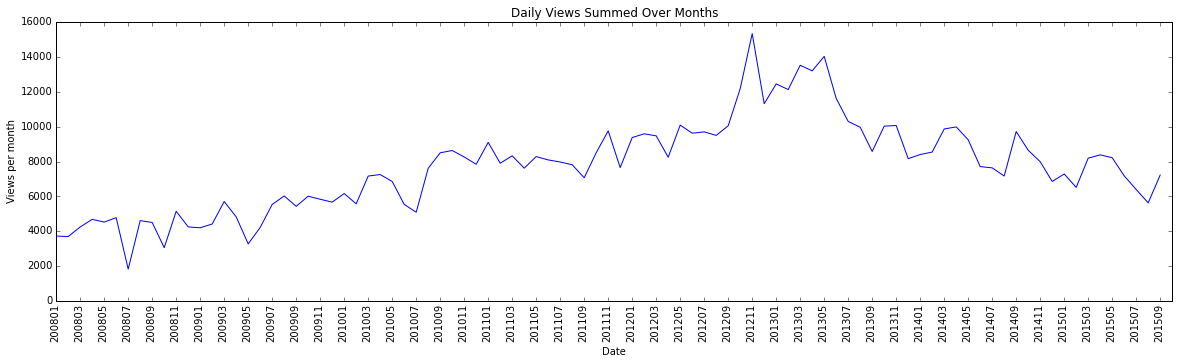

In [7]:
WikiViews.plot_time_series(tar)

## We want to explain this plot

We'd like to be able to know what high level topics influence the interest in the drug Tarceva.
We'll look for covariates and try to come up with some entry point ideas that we would present to a domain
export or analyst.

We would want to talk to a domain expert about that. Of course we an do some google searches of our own and try to find covariates. 

Google search about Tarcea turns up:

* Acts on, "Epidermal growth factor receptor" 
* Tarceva is also used to treat
 * Non small cell lung cancer
 * Pancreatic 
* Older drug named Iressa is the predecessor

Might as well do some more Wikipedia pulls, because it will be hard to find source to cross reference in the news that covers a span of time. Let's try "cancer", then maybe "lung cancer" and "iressa" which was the older drug for the same purpose.

In [8]:
wv = WikiViews("Epidermal_growth_factor_receptor", '1/1/2008', '10/1/2015'  )
egfr = wv.loop_over_full_dates()

In [10]:
wv = WikiViews("Lung_cancer", '1/1/2008', '10/1/2015')
lung = wv.loop_over_full_dates()

In [11]:
wv = WikiViews("Gefitinib", '1/1/2008', '10/1/2015' )
iressa = wv.loop_over_full_dates()

In [14]:
df = pd.concat({'month':tar.month, 
                'tar':tar.daily_views, 
                'egfr':egfr.daily_views,
                'lung':lung.daily_views,
                'iressa':iressa.daily_views
               }, axis=1)
df.head()
df.to_csv("/home/daniel/git/Python2.7/DataScience/wiki_views_data.csv", index=False)

In [29]:
df.head()

,egfr,iressa,lung,month,tar
2008-01-01,64,40,1357,200801,47
2008-01-02,156,81,2205,200801,133
2008-01-03,213,100,2728,200801,118
2008-01-04,174,89,2582,200801,108
2008-01-05,87,53,1885,200801,72


Examine for correlation by eye. We need to normalize to correct for scale. Note, the y label units will not be 
applicable for this plot.

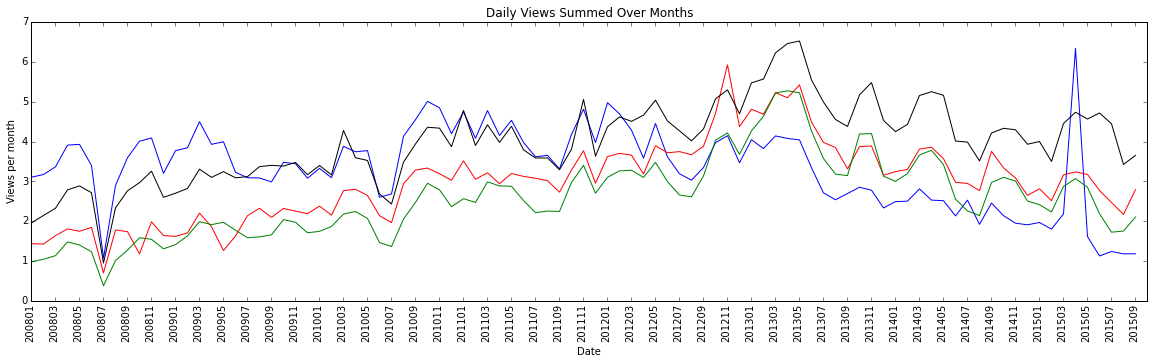

In [26]:
WikiViews.plot_time_series(lung, norm=True)
WikiViews.plot_time_series(tar, 'r', norm=True)
WikiViews.plot_time_series(egfr, 'g', norm=True)
WikiViews.plot_time_series(iressa, 'k', norm=True)

In [2]:
df = pd.read_csv("/home/daniel/git/Python2.7/DataScience/wiki_views_data.csv")

## Correlation

Recall, this is just a very basic exercise. We are using really obviously connected information to form a quick and dirty report suitable for an analysis to look at. We will need to search more for data which could be used to predict.

This is a normalized inner product.

In [3]:
cov = df[['tar', 'egfr','iressa','lung']]
print cov.shape
print "        Tarceva,     EGFR,     Iressa,     Lung cancer"
np.corrcoef(cov.T)

(2860, 4)
        Tarceva,     EGFR,     Iressa,     Lung cancer


array([[ 1.        ,  0.82129935,  0.77458023,  0.21085133],
       [ 0.82129935,  1.        ,  0.87244884,  0.22717227],
       [ 0.77458023,  0.87244884,  1.        ,  0.23527639],
       [ 0.21085133,  0.22717227,  0.23527639,  1.        ]])

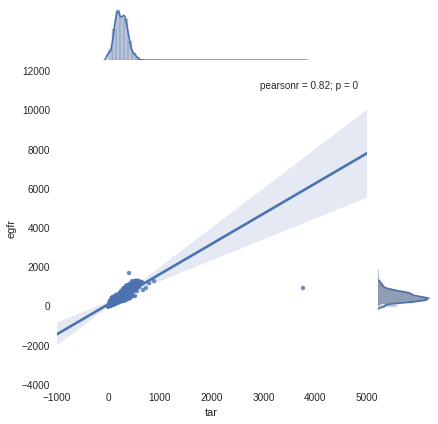

In [45]:
import seaborn as sns

sns.jointplot(x="tar", y="egfr", data=df, kind="reg");

## GLM with statsmodels

In [6]:
import statsmodels.api as sm
signal = df['tar']
cov = df[['egfr','iressa','lung']]
cov = np.asarray(cov.astype(np.float32))

signal = np.asarray(df['tar'].astype(np.float32))

# GLM
model = sm.GLM(signal, cov, family=sm.families.Gaussian())   
res = model.fit()

print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                 2860
Model:                            GLM   Df Residuals:                     2857
Model Family:                Gaussian   Df Model:                            2
Link Function:               identity   Scale:                   5785.60152446
Method:                          IRLS   Log-Likelihood:                -16445.
Date:                Wed, 07 Oct 2015   Deviance:                   1.6529e+07
Time:                        20:20:24   Pearson chi2:                 1.65e+07
No. Iterations:                     4                                         
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1             0.3221      0.011     28.216      0.000         0.300     0.344
x2             0.4569      0.032     14.358      0.0

# Moving on with numerical analysis technics
##  Filtering and FFT

Now we'd like to see some frequency anaylsis. The FFT won't tell us what day(s) the cycles repeat on,
but it will show if any periodicity exists. 

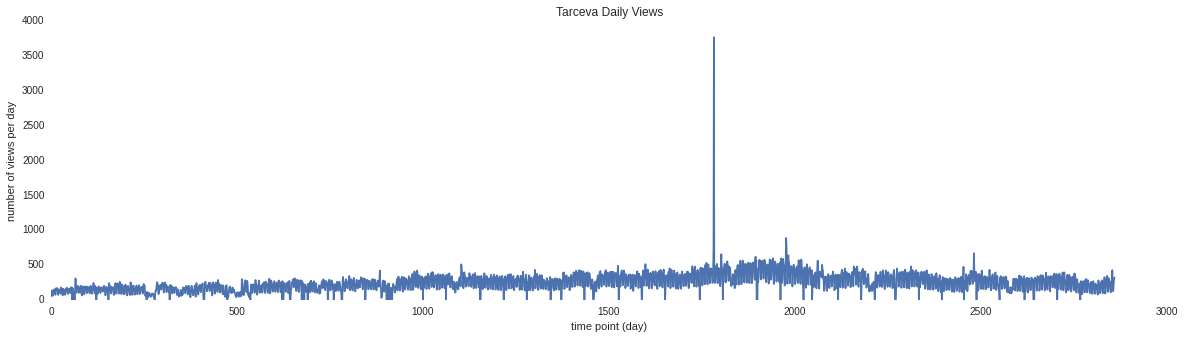

In [33]:
tar = df.tar
plt.plot(tar)
plt.title("Tarceva Daily Views")
plt.ylabel("number of views per day")
plt.xlabel("time point (day)")

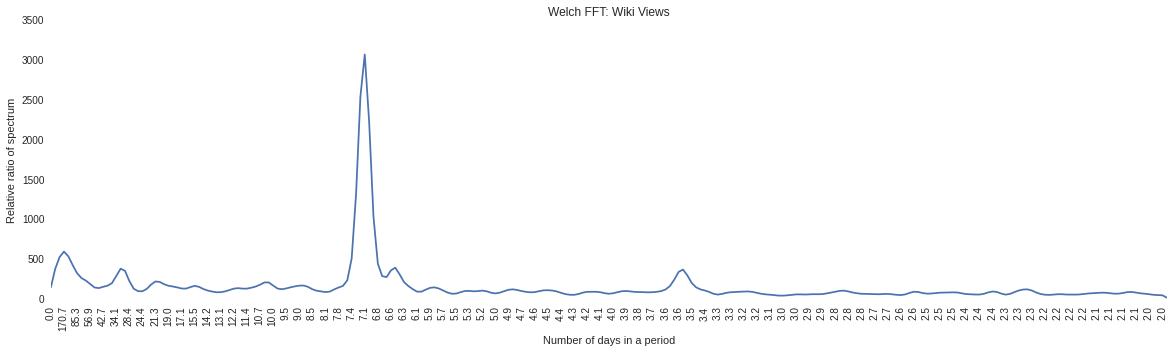

In [47]:
freq, amp = WikiViews.fft(tar)

There's a clear weekly frequency that I've seen in other social media channels. People may look use Wikipedia on the weekends more so than weekdays. The longer periods are interesting at about a month and three months. The next step would be to look for covarites to explain the time series and the periodicity. 

### Let's do some signal processing, in particular, Filtering
With straight numeric data from sensors ( typically voltages ), it's a lot more straight forward not to process the signals. There's samplerates, signal to noise ratios, published bandwidths....with social media NONE OF THAT EXISTS ! We either get our own parameters from more data or make heuristic guesses.

In [11]:
import scipy.signal as sig
data = df.tar

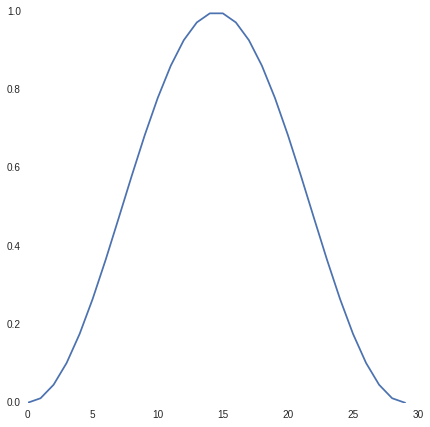

In [35]:
window = np.hanning(30)
plt.figure(figsize=(7,7))
plt.plot(window)

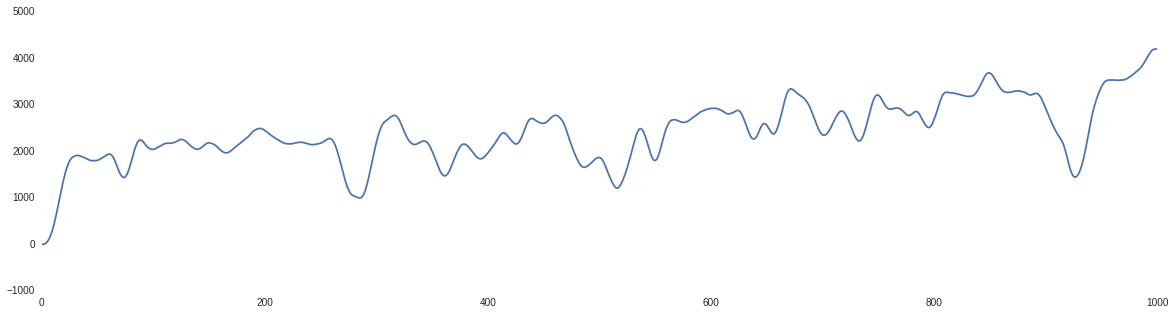

In [40]:
data_filt_30 = sig.fftconvolve(window, data)
plt.plot(data_filt_30[0:1000])

## Before the Filter

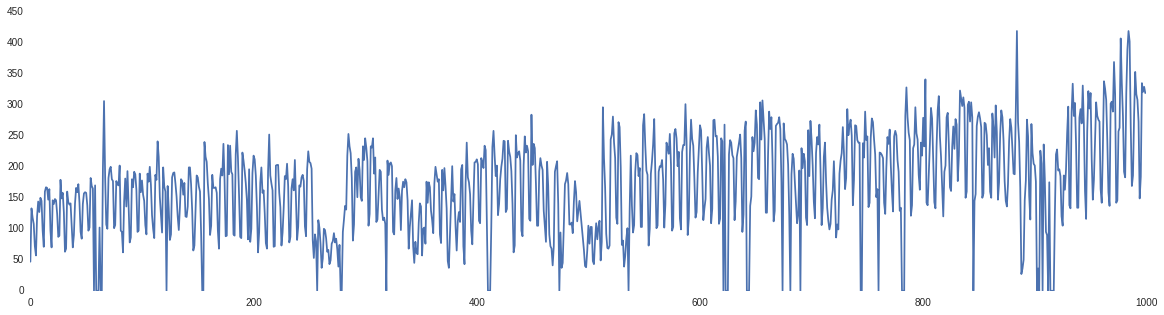

In [36]:
plt.figure()
plt.plot(data[0:1000])

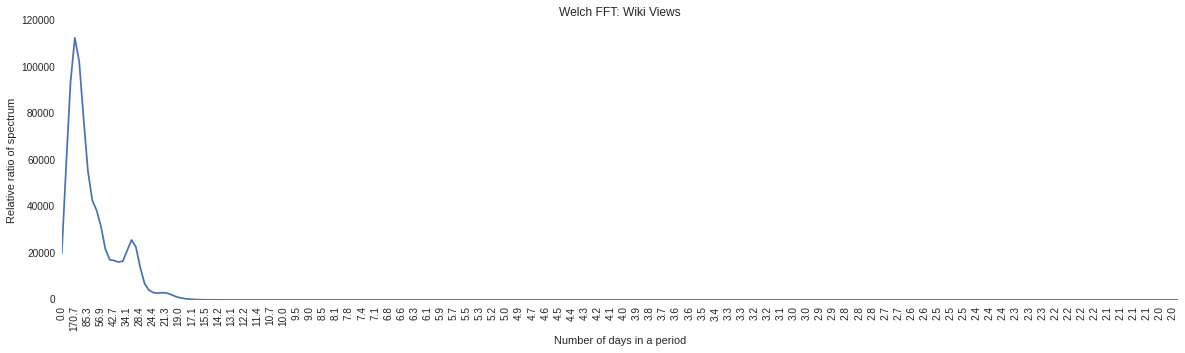

In [48]:
freq, y = WikiViews.fft(data_filt_30)

Although the peak looks bigger, there is no straight forward way to scale the y axis so we need to 
not be too impressed with that. Really, the same two peaks are present as in the original FFT. This plot is simply cleaner. This might seem dumb, but if we where writing a peak-detector, then we'd want a simpler data set.

Let's find peaks.

In [49]:
import SignalProcessTools
sigtools = SignalProcessTools.SignalProcessTools()

ImportError: cannot import name log_method

### The Savitzky-Golay filer was taken from here: http://wiki.scipy.org/Cookbook/SavitzkyGolay

In [50]:
def peak_detection(data):
    der1 = sigtools.savitzky_golay(data, window_size=3, order=1, deriv=1)
    der2 = sigtools.savitzky_golay(data, window_size=5, order=2, deriv=2)
    zero_crossings_test = der1[0:-1] * der1[1:]
    peaks = np.where((der2[0:-1] < 0) & (zero_crossings_test < 0))[0]
    
    return peaks

In [ ]:
peaks = peak_detection(data_filt_30)

In [ ]:
plt.plot(data_filt_30)
plt.vlines(peaks, 0, data_filt_30.max())

In [ ]:
peaks = peak_detection(y)
plt.figure()
plt.plot(freq, y)
plt.vlines(freq[peaks], 0, y.max(), 'r')

### There's still some ripple out to the right. We'll still need to use logic.



In [ ]:
y_peaks = y[peaks]
freq_peaks = freq[peaks]

peak_ref = np.max(y_peaks)
keep_peaks = np.where(y_peaks >= 0.1 * peak_ref)[0]

In [ ]:
plt.plot(freq, y)
plt.vlines(freq_peaks[keep_peaks], 0, y_peaks.max(), 'r')

# Generalizations about Wikipedia 

If we want to make some generalizations about Wikipedia viewership trends it would be safer to make these statements about the topics we've actually looked at. If we grab several random pages and they don't have significant depenence, then we can get a look at general trends. 

Since we have 3 cancer topics let's start simple and average those views. 

FFT and averaging are a linear operations, so it won't matter the order. Let's z-transform (center and normalize via std) then average and finally FFT the result.

In [ ]:
avg = df.daily_views.mean(0)
freq, amp = WikiViews.fft(avg)